# LangGraph + Text2SQL

## 1. 환경 설정

In [1]:
%load_ext autoreload
%autoreload 2

import sys, os

def add_python_path(module_path):
    if os.path.abspath(module_path) not in sys.path:
        sys.path.append(os.path.abspath(module_path))
        print(f"python path: {os.path.abspath(module_path)} is added")
    else:
        print(f"python path: {os.path.abspath(module_path)} already exists")
    print("sys.path: ", sys.path)


module_path = ".."
add_python_path(module_path)



python path: /home/sagemaker-user/Self-Study-Generative-AI/lab/10_advanced_agentic_text2sql is added
sys.path:  ['/home/sagemaker-user/.conda/envs/text2sql/lib/python310.zip', '/home/sagemaker-user/.conda/envs/text2sql/lib/python3.10', '/home/sagemaker-user/.conda/envs/text2sql/lib/python3.10/lib-dynload', '', '/home/sagemaker-user/.conda/envs/text2sql/lib/python3.10/site-packages', '/home/sagemaker-user/Self-Study-Generative-AI/lab/10_advanced_agentic_text2sql']


### 라이브러리 불러오기

In [2]:
from src.local_utils  import ( 
    converse_with_bedrock,
    init_boto3_client,
    init_search_resources,
    get_column_description,
    search_by_keywords,
    create_prompt,
    NodeTester,
    csv_list_response_format,
    json_response_format,
    # wrapped_bedrock_converse
    converse_with_bedrock_langfuse,
)

import boto3
import json
import copy
from botocore.config import Config

from langchain_aws import BedrockEmbeddings
from langchain_community.utilities import SQLDatabase
from sqlalchemy import create_engine
from src.opensearch import OpenSearchHybridRetriever, OpenSearchClient
from textwrap import dedent
from langfuse.decorators import observe



### LLM 모델 설정

In [104]:
# llm_model = "us.amazon.nova-pro-v1:0"
llm_model = "us.anthropic.claude-3-7-sonnet-20250219-v1:0"
# llm_model = "us.anthropic.claude-3-5-sonnet-20240620-v1:0"
# llm_model = "us.anthropic.claude-3-5-haiku-20241022-v1:0"
# llm_model = "us.anthropic.claude-3-sonnet-20240229-v1:0"
# llm_model = "anthropic.claude-3-sonnet-20240229-v1:0"

### Langfuse 설정

In [88]:
from dotenv import load_dotenv
import os

# .env 파일에서 환경 변수 로드
load_dotenv("../.env")

from langfuse.callback import CallbackHandler
import os

langfuse_handler = CallbackHandler(
    public_key=os.environ.get('LANGFUSE_PUBLIC_KEY'),
    secret_key=os.environ.get('LANGFUSE_SECRET_KEY'),
    host=os.environ.get('LANGFUSE_HOST'),
)

# connection test
print("Langfuse 인증 테스트:", langfuse_handler.auth_check())


from langfuse.callback import CallbackHandler
import os

langfuse_handler = CallbackHandler(
    public_key=os.environ.get('LANGFUSE_PUBLIC_KEY'),
    secret_key=os.environ.get('LANGFUSE_SECRET_KEY'),
    host=os.environ.get('LANGFUSE_HOST'),
)

Langfuse 인증 테스트: True


### DB Engine 및 오브젝트 정의

In [89]:
engine = create_engine("sqlite:///Chinook.db")
db = SQLDatabase(engine)
DIALECT = "sqlite"

session = boto3.session.Session()
region_name = session.region_name
print(f"현재 리전: {region_name}")

boto3_client = init_boto3_client(region_name)
sql_search_client, table_search_client, sql_retriever, table_retriever = init_search_resources(region_name, k=5)



현재 리전: us-east-1


## 2. 검색 기능 테스트

In [90]:
# 검색 키워드 예시
# keyword = "사람들이 좋아하는 장르"
keyword = "2022년 매출 상위 10개 국가는?"

sql_search_result = sql_retriever.invoke(keyword, ensemble=[0.60, 0.40])
# sql_search_result = sql_retriever.invoke(keyword, ensemble=[0.51, 0.49])
table_search_result = table_retriever.invoke(keyword, ensemble=[0.60, 0.40])

if sql_search_result:
    page_content = json.loads(sql_search_result[0].page_content)
    print("샘플 쿼리 검색 결과: ", json.dumps(page_content, indent=4, ensure_ascii=False))

if table_search_result:
    page_content = json.loads(table_search_result[0].page_content)
    print("테이블 검색 결과: ", json.dumps(page_content, indent=4, ensure_ascii=False))

샘플 쿼리 검색 결과:  {
    "input": "총 금액이 10을 초과하는 인보이스 내역 조회. 고객의 높은 가치 거래 파악 및 우대 정책 수립, 매출 분석, 재고 관리 등의 목적으로 활용 가능합니다.",
    "query": "SELECT * FROM Invoice WHERE Total > 10"
}
테이블 검색 결과:  {
    "table_name": "Invoice",
    "table_summary": "이 테이블은 고객과 관련된 거래 내역을 기록하고 있습니다. 각 거래에 대해 인보이스 ID, 고객 ID, 인보이스 날짜, 청구 주소, 청구 도시, 청구 주/도, 청구 국가, 청구 우편번호 및 총 금액 등의 정보를 포함하고 있습니다.\n\n이 테이블을 활용하여 다음과 같은 분석이 가능합니다:\n\n- 전체 거래 건수 및 총 매출 규모 파악\n- 고객별 총 구매 금액 분석 및 상위 고객 식별 \n- 고가 거래 내역 추출 및 분석\n- 대량 주문 내역 추출 및 분석\n- 시간별, 지역별 매출 동향 분석\n- 고객 세그멘테이션 및 타겟 마케팅 전략 수립\n- 재고 관리 및 운영 계획 수립\n- 영업 실적 평가 및 성과 분석\n\n이 테이블의 데이터를 활용하면 회사의 매출 현황, 고객 행동 패턴, 운영 효율성 등을 종합적으로 파악할 수 있어 비즈니스 의사결정에 핵심 인사이트를 제공할 수 있습니다."
}


In [91]:
# for result in sql_search_result:
#     page_content = json.loads(result.page_content)
#     print("샘플 쿼리 검색 결과: ", json.dumps(page_content, indent=4, ensure_ascii=False))


## 3. LangGraph 

### 그래프 상태 설정

In [92]:
from typing import TypedDict

class GraphState(TypedDict):
    question: str  
    intent: str
    sample_queries: list
    readiness: str
    selected_group: str  # 선택된 테이블 그룹의 이름 (music_content, user_playlists, business_sales, cross_domain)
    group_tables: list   # 선택된 그룹에 속한 모든 테이블 목록    
    table_contents: list  # 테이블 컨텐츠 원본 데이터를 저장하는 필드 (추가됨)
    table_names: list  # 테이블 이름 목록
    table_details: list  # 테이블 세부 정보
    query_state: dict  # 쿼리 상태 정보
    next_action: str  # 다음 실행 액션
    answer: str  # 최종 답변
    dialect: str  # SQL 방언 정보
    readiness_attempts: int  # readyness 실패 횟수 추적
    failure_count: int  # 실패 횟수 추적 

## 4. 서브그래프1 - 의도 분류 및 주제 도메인 분류

### analyze_intent 함수 정의

In [115]:
# @observe(name="Analyze Intent Node")
def analyze_intent(state: GraphState) -> GraphState:
    question = state["question"]
    sys_prompt_template = dedent("""당신은 사용자 질문의 의도를 파악하는 비서입니다. 
                                    당신의 임무는 사용자 질문을 하나로 분류하는 것입니다.""")
    usr_prompt_template = dedent("""사용자 질문을 해결하기 위해 데이터베이스 조회가 필요하면 `database` 그 밖의 경우는 `general`로만 응답하세요.
                                    추가 설명이나 이유를 포함하지 마세요. 단어 하나만 정확히 응답하세요.
                                    서두는 생략하세요.
                                    \n\n #질문: {question}""")
    sys_prompt, usr_prompt = create_prompt(sys_prompt_template, usr_prompt_template, question=question)
    # intent = converse_with_bedrock(sys_prompt, usr_prompt)
    intent = converse_with_bedrock_langfuse(sys_prompt, usr_prompt, model_id=llm_model, function_name="analyze_intent")

    return GraphState(intent=intent)

In [119]:
node_tester = NodeTester()
# test_state = {
#     "question": "2022년 매출 상위 10개 국가는?",
# }
test_state = {
    "question": "지난 분기에 가장 많은 매출을 올린 5명의 직원과 각 직원이 담당한 고객 수를 보여줘"
}

# test_state = {
#     "question": "지난 분기에 가장 많은 매출을 올린 5명의 직원과 각 직원이 담당한 고객 수를 보여줘", 
# }

result_state = node_tester.test(analyze_intent, test_state)

## Test Result:
{
  "intent": "database"
}


### select_table_group 함수 정의

In [120]:
def select_table_group(state):
    """사용자 질의를 분석하여 적합한 테이블 그룹을 선택하는 함수"""
    question = state["question"]
    sys_prompt_template = dedent("""당신은 데이터베이스 스키마를 이해하고 사용자 질문을 분석하는 데이터베이스 전문가입니다.
                                    주어진 질문을 분석하여 가장 관련성이 높은 테이블 그룹을 식별하는 것이 당신의 임무입니다.
                                """)
    
    usr_prompt_template = dedent("""사용자의 질문을 분석하여 가장 관련성이 높은 테이블 그룹 하나만 선택하세요.
                                    다음 중 하나로만 응답하세요: music_content, user_playlists, business_sales, cross_domain
                                    각 그룹에 포함된 테이블은 다음과 같습니다:
                                    - music_content: Album, Artist, Track, Genre, MediaType
                                    - user_playlists: Playlist, PlaylistTrack
                                    - business_sales: Customer, Employee, Invoice, InvoiceLine
                                    - cross_domain: 모든 테이블 (복잡한 다중 도메인 질의용)
                                    그룹명만 답변하세요. 추가 설명이나 이유를 포함하지 마세요.
                                    #질문: {question}""")
    
    sys_prompt, usr_prompt = create_prompt(sys_prompt_template, usr_prompt_template, question=question)
    selected_group = converse_with_bedrock_langfuse(sys_prompt, usr_prompt, model_id=llm_model, function_name="select_table_group")

    # 선택된 그룹에 따른 테이블 목록을 상태에 저장
    TABLE_GROUPS = {
        "music_content": ["Album", "Artist", "Track", "Genre", "MediaType"],
        "user_playlists": ["Playlist", "PlaylistTrack"],
        "business_sales": ["Customer", "Employee", "Invoice", "InvoiceLine"],
        "cross_domain": ["Album", "Artist", "Track", "Genre", "MediaType", "Playlist", "PlaylistTrack", "Customer", "Employee", "Invoice", "InvoiceLine"]
    }
    group_tables = TABLE_GROUPS.get(selected_group, TABLE_GROUPS["cross_domain"])
    
    return GraphState(selected_group=selected_group, group_tables=group_tables)

In [121]:
def test_node(node_tester, node_function, test_state,result_state ):
    # test_state와 result_state를 합쳐서 test_state2 생성
    test_state = {**test_state, **result_state}
    print("## test_state: ")
    print(json.dumps(test_state, indent=2, ensure_ascii=False))

    result_state = node_tester.test(node_function, test_state)
    return result_state, test_state


result_state, test_state = test_node(node_tester=node_tester, 
                            node_function=select_table_group, 
                            test_state=test_state,
                            result_state=result_state )


## test_state: 
{
  "question": "지난 분기에 가장 많은 매출을 올린 5명의 직원과 각 직원이 담당한 고객 수를 보여줘",
  "intent": "database"
}
## Test Result:
{
  "selected_group": "business_sales",
  "group_tables": [
    "Customer",
    "Employee",
    "Invoice",
    "InvoiceLine"
  ]
}


### get_table_contents 함수 정의

In [97]:
def get_table_contents(state: GraphState) -> GraphState:
    """그룹 테이블 정보를 검색하고 중복 없이 반환하는 함수"""
    selected_group = state.get("selected_group", "cross_domain")
    group_tables = state.get("group_tables", [])
    
    # 테이블 정보 검색 및 파싱
    table_contents = []
    seen_tables = set()
    
    # 선택된 그룹 테이블만 처리
    tables_to_search = group_tables if selected_group and group_tables else []
    
    # 테이블이 없거나 cross_domain이면 전체 검색
    if not tables_to_search or selected_group == "cross_domain":
        docs = table_retriever.invoke(state["question"], ensemble=[0.40, 0.60])
        # print("## docs: \n", docs)
    else:
        # 선택된 그룹의 테이블만 검색
        docs = []
        for table_name in tables_to_search:
            docs.extend(table_retriever.invoke(table_name, ensemble=[1.0, 0.0]) or [])
    
    # 검색 결과 처리
    for doc in [d for d in docs if d]:
        try:
            content = json.loads(doc.page_content)
            table_name = content.get("table_name")
            
            # 그룹 필터링 및 중복 처리
            if (table_name 
                and table_name not in seen_tables
                and (selected_group == "cross_domain" or table_name in group_tables)):
                table_contents.append(content)
                seen_tables.add(table_name)
        except json.JSONDecodeError:
            pass
    
    return GraphState(table_contents=table_contents)

In [98]:
result_state, test_state = test_node(node_tester=node_tester, 
                            node_function=get_table_contents, 
                            test_state=test_state,
                            result_state=result_state )


## test_state: 
{
  "question": "재즈와 블루스 장르의 트랙만 포함된 플레이리스트를 모두 찾아줘.",
  "intent": "database",
  "selected_group": "cross_domain",
  "group_tables": [
    "Album",
    "Artist",
    "Track",
    "Genre",
    "MediaType",
    "Playlist",
    "PlaylistTrack",
    "Customer",
    "Employee",
    "Invoice",
    "InvoiceLine"
  ]
}
## Test Result:
{
  "table_contents": [
    {
      "table_name": "PlaylistTrack",
      "table_summary": "이 테이블은 플레이리스트와 트랙 간의 관계를 나타냅니다. PlaylistId 열은 플레이리스트를 식별하는 외래 키이며, TrackId 열은 플레이리스트에 포함된 트랙을 식별하는 외래 키입니다. \n\n이 테이블을 통해 다음과 같은 분석이 가능합니다:\n\n- 특정 플레이리스트에 포함된 트랙 목록 확인\n- 특정 트랙이 포함된 플레이리스트 목록 확인\n- 플레이리스트별 트랙 수 분석\n- 플레이리스트 간 공통 트랙 비교 분석\n- 사용자 취향에 맞는 새로운 플레이리스트 추천\n\n이 테이블은 음악 스트리밍 서비스에서 사용자의 플레이리스트 관리 및 개인화된 추천 기능을 구현하는 데 활용될 수 있습니다."
    },
    {
      "table_name": "Playlist",
      "table_summary": "이 테이블은 플레이리스트에 대한 정보를 저장합니다. 각 행은 고유한 PlaylistId로 식별되는 플레이리스트를 나타내며, Name 열에는 해당 플레이리스트의 이름이 저장됩니다.\n\n이 테이블을 활용하여 다음과 같은 작업을 수행할 수 있습니다:\n\n- 사용자가 생성한 모든 

### select_relevant_tables 함수 정의

In [99]:
def select_relevant_tables(state: GraphState) -> GraphState:
    """사용자 질의와 관련된 테이블을 선택하는 함수"""
    question = state["question"]
    selected_group = state.get("selected_group", "cross_domain")
    group_tables = state.get("group_tables", [])
    table_contents = state.get("table_contents", [])
        
    # 테이블 요약 정보를 변수에 담기
    table_summaries = [content.get('table_summary', '') for content in table_contents]
    
    sys_prompt = "SQL 쿼리 작성에 필요한 테이블을 선택하세요."
    usr_prompt = dedent(f"""질문에 필요한 테이블을 인덱스 번호(0부터)로만 응답하세요. 
                    
                    #질문: {question}
                    #테이블: {table_summaries}
                    #형식: {csv_list_response_format}""")
                    
    # LLM 호출
    table_ids = converse_with_bedrock_langfuse(
        [{"text": sys_prompt}], 
        [{"role": "user", "content": [{"text": usr_prompt}]}], 
        model_id=llm_model, 
        function_name="select_relevant_tables"
    )
    
    try:
        # 응답 처리
        if not table_ids or table_ids.strip() in ['""', '']:
            return GraphState(**state, tables=[], table_names=[])
        
        # 테이블 선택
        id_list = [int(id.strip()) for id in table_ids.split(',') if id.strip().isdigit() and int(id.strip()) < len(table_contents)]
        tables = [table_contents[i] for i in id_list]
        table_names = [t.get('table_name', '') for t in tables]
            
        return GraphState(table_names=table_names)
    except:
        return GraphState(table_names=[])

In [100]:
result_state, test_state = test_node(node_tester=node_tester, 
                            node_function=select_relevant_tables, 
                            test_state=test_state,
                            result_state=result_state )


## test_state: 
{
  "question": "재즈와 블루스 장르의 트랙만 포함된 플레이리스트를 모두 찾아줘.",
  "intent": "database",
  "selected_group": "cross_domain",
  "group_tables": [
    "Album",
    "Artist",
    "Track",
    "Genre",
    "MediaType",
    "Playlist",
    "PlaylistTrack",
    "Customer",
    "Employee",
    "Invoice",
    "InvoiceLine"
  ],
  "table_contents": [
    {
      "table_name": "PlaylistTrack",
      "table_summary": "이 테이블은 플레이리스트와 트랙 간의 관계를 나타냅니다. PlaylistId 열은 플레이리스트를 식별하는 외래 키이며, TrackId 열은 플레이리스트에 포함된 트랙을 식별하는 외래 키입니다. \n\n이 테이블을 통해 다음과 같은 분석이 가능합니다:\n\n- 특정 플레이리스트에 포함된 트랙 목록 확인\n- 특정 트랙이 포함된 플레이리스트 목록 확인\n- 플레이리스트별 트랙 수 분석\n- 플레이리스트 간 공통 트랙 비교 분석\n- 사용자 취향에 맞는 새로운 플레이리스트 추천\n\n이 테이블은 음악 스트리밍 서비스에서 사용자의 플레이리스트 관리 및 개인화된 추천 기능을 구현하는 데 활용될 수 있습니다."
    },
    {
      "table_name": "Playlist",
      "table_summary": "이 테이블은 플레이리스트에 대한 정보를 저장합니다. 각 행은 고유한 PlaylistId로 식별되는 플레이리스트를 나타내며, Name 열에는 해당 플레이리스트의 이름이 저장됩니다.\n\n이 테이블을 활용하여 다음과 같은 작업을 수행할 수 있습니다:\n\n- 사용자가 생성한 모든 플레이리스트 목록 조회\n- 특정 

### get_sample_queries 함수 정의

In [101]:
def get_sample_queries(state: GraphState) -> GraphState:
    """질문과 선택된 테이블에 관련된 샘플 쿼리를 선택하는 함수"""
    question = state["question"]
    table_names = state.get("table_names", [])
        
    # 관련 샘플 쿼리 검색
    samples = sql_retriever.invoke(question, ensemble=[0.80, 0.20])
    page_contents = [doc.page_content for doc in samples if doc is not None]
    
    # 샘플 목록 준비 (한글 텍스트로 변환)
    sample_inputs = []
    for content in page_contents:
        try:
            sample = json.loads(content)
            input_text = sample.get('input', '')
            query_text = sample.get('query', '')
            sample_inputs.append(f"설명: {input_text}\n쿼리: {query_text}")
        except:
            continue
    
    # 인덱스가 포함된 샘플 목록 만들기
    indexed_samples = ""
    for i, input_text in enumerate(sample_inputs):
        indexed_samples += f"[{i}] {input_text}\n"
    
    # 프롬프트 준비
    sys_prompt = f"질문과 관련되고 {table_names} 테이블을 사용하는 SQL 쿼리 샘플을 선택하세요."
    
    usr_prompt = dedent(f"""다음 테이블을 사용하는 쿼리만 선택하세요: {table_names}
                  관련 샘플 인덱스 번호(0부터)만 응답하세요. 없으면 빈 목록("")으로 응답.
                  #질문: {question}
                  #샘플 쿼리:
                  {indexed_samples}
                  #형식: {csv_list_response_format}""")
    
    # LLM 호출
    sample_ids = converse_with_bedrock_langfuse(
        [{"text": sys_prompt}], 
        [{"role": "user", "content": [{"text": usr_prompt}]}], 
        model_id=llm_model, 
        function_name="get_sample_queries"
    )
    
    try:
        # 빈 응답 처리
        if not sample_ids or sample_ids.strip() in ['""', '', '[]']:
            return GraphState(sample_queries=[])
        
        # 선택된 샘플 쿼리 추출
        sample_ids_list = [int(id.strip()) for id in sample_ids.split(',') 
                          if id.strip().isdigit() and int(id.strip()) < len(page_contents)]
        
        sample_queries = [json.loads(page_contents[id]) for id in sample_ids_list]
        return GraphState(sample_queries=sample_queries)
    except:
        return GraphState(sample_queries=[])

In [102]:
result_state2, test_state2 = test_node(node_tester=node_tester, 
                            node_function=get_sample_queries, 
                            test_state=test_state,
                            result_state=result_state )

## test_state: 
{
  "question": "재즈와 블루스 장르의 트랙만 포함된 플레이리스트를 모두 찾아줘.",
  "intent": "database",
  "selected_group": "cross_domain",
  "group_tables": [
    "Album",
    "Artist",
    "Track",
    "Genre",
    "MediaType",
    "Playlist",
    "PlaylistTrack",
    "Customer",
    "Employee",
    "Invoice",
    "InvoiceLine"
  ],
  "table_contents": [
    {
      "table_name": "PlaylistTrack",
      "table_summary": "이 테이블은 플레이리스트와 트랙 간의 관계를 나타냅니다. PlaylistId 열은 플레이리스트를 식별하는 외래 키이며, TrackId 열은 플레이리스트에 포함된 트랙을 식별하는 외래 키입니다. \n\n이 테이블을 통해 다음과 같은 분석이 가능합니다:\n\n- 특정 플레이리스트에 포함된 트랙 목록 확인\n- 특정 트랙이 포함된 플레이리스트 목록 확인\n- 플레이리스트별 트랙 수 분석\n- 플레이리스트 간 공통 트랙 비교 분석\n- 사용자 취향에 맞는 새로운 플레이리스트 추천\n\n이 테이블은 음악 스트리밍 서비스에서 사용자의 플레이리스트 관리 및 개인화된 추천 기능을 구현하는 데 활용될 수 있습니다."
    },
    {
      "table_name": "Playlist",
      "table_summary": "이 테이블은 플레이리스트에 대한 정보를 저장합니다. 각 행은 고유한 PlaylistId로 식별되는 플레이리스트를 나타내며, Name 열에는 해당 플레이리스트의 이름이 저장됩니다.\n\n이 테이블을 활용하여 다음과 같은 작업을 수행할 수 있습니다:\n\n- 사용자가 생성한 모든 플레이리스트 목록 조회\n- 특정 

### check_readiness 함수 정의

In [19]:
def check_readiness(state: GraphState) -> GraphState:

    # 시도 횟수 추적 (없으면 0으로 초기화)
    readiness_attempts = state.get("readiness_attempts", 0)
    readiness_attempts += 1

    # 시도 횟수가 3번 이상이면 종료 상태로 설정
    if readiness_attempts >= 3:
        return GraphState(readiness="Max Attempts", readiness_attempts=readiness_attempts)    
    
    question = state["question"]
    sample_queries = state["sample_queries"]

    if "table_details" in state:
        table_details = state["table_details"]
    else:
        table_details = []

    sys_prompt_template = dedent("""당신은 사용자 질문에 대한 SQL 쿼리를 작성하는 유능한 데이터베이스 엔지니어입니다. 
                                    당신의 임무는 주어진 DB 정보를 바탕으로, 사용자 질문에 대한 SQL 쿼리 작성이 가능한지 판단하는 것입니다.""")

    usr_prompt_template = dedent("""질문에 대한 SQL 쿼리를 생성하기에 충분한 정보가 제공되었는지 판단하세요.
                                중요: 'Ready' 또는 'Not Ready' 중 하나만 정확히 응답하세요.
                                서두, 설명, 추가 분석 등은 포함하지 마세요.
                                예시:
                                - 정보가 충분한 경우 응답: Ready
                                - 정보가 부족한 경우 응답: Not Ready                                
                                #질문: {question}
                                #샘플 쿼리:
                                {sample_queries}
                                #사용 가능한 테이블 스키마:
                                {table_details}
                                응답 (단일 단어만)
                                """)
    sys_prompt, usr_prompt = create_prompt(sys_prompt_template, usr_prompt_template, question=question, sample_queries=sample_queries, table_details=table_details)
    # readiness = converse_with_bedrock(sys_prompt, usr_prompt)
    readiness = converse_with_bedrock_langfuse(sys_prompt, usr_prompt, model_id=llm_model, function_name="check_readiness")    
    
    return GraphState(readiness=readiness, readiness_attempts=readiness_attempts)


In [23]:
result_state, test_state = test_node(node_tester=node_tester, 
                            node_function=check_readiness, 
                            test_state=test_state,
                            result_state=result_state )


## test_state: 
{
  "question": "각 장르별 트랙의 평균 가격과 총 트랙 수를 계산해줘.",
  "intent": "database",
  "selected_group": "music_content",
  "group_tables": [
    "Album",
    "Artist",
    "Track",
    "Genre",
    "MediaType"
  ],
  "table_contents": [
    {
      "table_name": "Album",
      "table_summary": "이 테이블은 음악 앨범에 대한 정보를 저장하고 있습니다. 각 앨범은 고유한 AlbumId를 가지며, Title과 ArtistId 열이 포함되어 있습니다. Title은 앨범의 제목을, ArtistId는 해당 앨범의 아티스트 정보를 다른 테이블과 연결하는 외래 키입니다.\n\n이 테이블을 활용하면 다음과 같은 분석이 가능합니다:\n\n1. 특정 아티스트의 전체 앨범 목록 조회\n2. 앨범별 수록곡 수 확인 및 비교\n3. 라이브 공연 실황 앨범 식별 및 분석\n4. 신규 앨범 추가 및 기존 앨범 정보 업데이트\n5. 아티스트 및 장르별 앨범 통계 분석\n6. 인기 앨범 판매 데이터와 연계한 마케팅 전략 수립\n\n이 테이블은 음악 스트리밍 서비스, 음반사, 음악 매체 등에서 앨범 정보 관리와 다양한 분석에 활용될 수 있습니다. 아티스트의 디스코그래피 정보를 제공하거나 사용자 취향에 맞는 앨범을 추천하는 데에도 도움이 될 것입니다."
    },
    {
      "table_name": "Genre",
      "table_summary": "이 테이블은 음악 장르에 대한 정보를 저장하고 있습니다. 각 장르는 고유한 GenreId와 Name 열로 구성되어 있습니다.\n\nGenreId 열은 장르의 고유 식별자 역할을 하며, Name 열은 해당 장르의 이름을 저장합니다.\n\n이 테이블을 활용하면 다음과 같은 작업이 가능합니다:\

### describe_schema 함수 정의

In [21]:
def describe_schema(state: GraphState) -> GraphState:
    table_names = state["table_names"]
    table_details = []
    data = db.get_table_info_no_throw(table_names)
    
    if not isinstance(data, list):
        data = [data]
    
    for item in data:
        if isinstance(item, str):
            items = item.split('CREATE TABLE')
        else:
            items = [item]
        
        for i in range(1, len(items)):
            sub_item = 'CREATE TABLE' + items[i]
            for table_name in table_names:
                if f'CREATE TABLE "{table_name}"' in sub_item:
                    
                    parts = sub_item.split('/*', 1)
                    sql_statement = parts[0].strip()
                    
                    sample_data = "No sample data available"
                    if len(parts) > 1:
                        sample_part = parts[1].split('*/', 1)[0] 
                        sample_lines = sample_part.strip().split('\n')
                        if len(sample_lines) > 1:
                            sample_data = '\n'.join(sample_lines)
                    
                    table_desc = get_column_description(table_name) if table_search_client else {}        
                    table_detail = {
                        "table": table_name,
                        "cols": table_desc if table_desc else {},
                        "create_table_sql": sql_statement,
                        "sample_data": sample_data
                    }
                    
                    if not table_detail["cols"]:
                        print(f"No columns found for table {table_name}")
                    table_details.append(table_detail)
                    
    return GraphState(table_details=table_details)


In [22]:
result_state, test_state = test_node(node_tester=node_tester, 
                            node_function=describe_schema, 
                            test_state=test_state,
                            result_state=result_state )


## test_state: 
{
  "question": "각 장르별 트랙의 평균 가격과 총 트랙 수를 계산해줘.",
  "intent": "database",
  "selected_group": "music_content",
  "group_tables": [
    "Album",
    "Artist",
    "Track",
    "Genre",
    "MediaType"
  ],
  "table_contents": [
    {
      "table_name": "Album",
      "table_summary": "이 테이블은 음악 앨범에 대한 정보를 저장하고 있습니다. 각 앨범은 고유한 AlbumId를 가지며, Title과 ArtistId 열이 포함되어 있습니다. Title은 앨범의 제목을, ArtistId는 해당 앨범의 아티스트 정보를 다른 테이블과 연결하는 외래 키입니다.\n\n이 테이블을 활용하면 다음과 같은 분석이 가능합니다:\n\n1. 특정 아티스트의 전체 앨범 목록 조회\n2. 앨범별 수록곡 수 확인 및 비교\n3. 라이브 공연 실황 앨범 식별 및 분석\n4. 신규 앨범 추가 및 기존 앨범 정보 업데이트\n5. 아티스트 및 장르별 앨범 통계 분석\n6. 인기 앨범 판매 데이터와 연계한 마케팅 전략 수립\n\n이 테이블은 음악 스트리밍 서비스, 음반사, 음악 매체 등에서 앨범 정보 관리와 다양한 분석에 활용될 수 있습니다. 아티스트의 디스코그래피 정보를 제공하거나 사용자 취향에 맞는 앨범을 추천하는 데에도 도움이 될 것입니다."
    },
    {
      "table_name": "Genre",
      "table_summary": "이 테이블은 음악 장르에 대한 정보를 저장하고 있습니다. 각 장르는 고유한 GenreId와 Name 열로 구성되어 있습니다.\n\nGenreId 열은 장르의 고유 식별자 역할을 하며, Name 열은 해당 장르의 이름을 저장합니다.\n\n이 테이블을 활용하면 다음과 같은 작업이 가능합니다:\

### handle_insufficient_info 함수 정의

In [24]:
# 새로운 노드 추가: 정보 부족으로 인한 종료 처리
def handle_insufficient_info(state: GraphState) -> GraphState:
    """정보 부족으로 쿼리를 생성할 수 없을 때 응답 생성"""
    question = state["question"]
    sample_queries = state["sample_queries"]
    table_details = state["table_details"]

    sys_prompt = "사용자 질문에 대해 필요한 정보가 부족하여 정확한 SQL 쿼리를 생성할 수 없음을 설명하세요."
    usr_prompt = dedent(f"""질문에 대한 SQL 쿼리를 생성하기 위한 정보가 충분하지 않습니다.                    
                    이 상황에서 사용자에게 정보 부족으로 정확한 쿼리를 생성할 수 없음을 설명하고, 
                    어떤 추가 정보가 필요한지 안내해주세요.
                    #질문: {question}
                    #샘플 쿼리:
                    {sample_queries}
                    #사용 가능한 테이블 스키마:
                    {table_details}
                    """)
    
    # LLM 호출
    answer = converse_with_bedrock_langfuse(
        [{"text": sys_prompt}], 
        [{"role": "user", "content": [{"text": usr_prompt}]}], 
        model_id=llm_model, 
        function_name="handle_insufficient_info"
    )
    
    return GraphState(answer=answer)

### Edge 함수 정의

In [25]:
def next_step_by_readiness_with_max_attempts(state: GraphState) -> GraphState:
    """readiness 상태에 따라 다음 단계를 결정하는 함수 (최대 시도 횟수 제한 추가)"""
    readiness = state.get("readiness", "")
    
    return readiness

    
def next_step_by_intent(state: GraphState) -> GraphState:
    return state["intent"]

def next_step_by_readiness(state: GraphState) -> GraphState:
    return state["readiness"]



## 5. 서브그래프2 - 쿼리 생성/검증/실행/재시도

### generate_query 함수 정의

In [26]:
### Query Generation & Execution - SubGraph2

initial_query_state = {
    "status": "success",
    "query": "",
    "result": "",
    "error": {
        "code": "",
        "message": "",
        "failed_step": "",
        "hint": ""
    }
}
dialect = DIALECT
def generate_query(state: GraphState) -> GraphState:
    new_query_state = copy.deepcopy(initial_query_state)
    question = state["question"]
    sample_queries = state["sample_queries"]
    table_details = state["table_details"]

    query_state = state.get("query_state", {}) or {}
    error_info = query_state.get("error", {}) or {}
    hint = error_info.get("message", "None")    

    # print("## query_state: \n", query_state)    
    # print("## error_info: \n", error_info)
    
    # print("## hint: \n", hint)
    
    sys_prompt_template = dedent("""당신은 사용자 질문에 대한 {dialect} SQL 쿼리를 작성하는 유능한 데이터베이스 엔지니어입니다. 
                                당신의 임무는 주어진 DB 정보를 바탕으로, 사용자 질문에 부합하는 정확한 SQL 쿼리를 작성하는 것입니다.""")
    usr_prompt_template = dedent("""다음 주어진 정보를 바탕으로 SQL 쿼리를 작성하세요.
                                중요: 오직 실행 가능한 SQL 쿼리 구문만 반환하세요. 다음 사항을 반드시 준수하세요:
                                - 설명, 주석, 서두 없이
                                - 코드 블록 표시(```) 없이
                                - SQL 앞뒤에 어떤 텍스트도 추가하지 않고
                                - 순수한 SQL 쿼리만 정확히 제공
                                #질문: {question}\n\n 
                                #샘플 쿼리:\n {sample_queries}\n\n 
                                #사용 가능한 테이블:\n {table_details}\n\n, 
                                #추가 정보 (과거 실패 이력, 추가 획득한 정보 등):\n {hint}""")

    
    sys_prompt, usr_prompt = create_prompt(sys_prompt_template, usr_prompt_template, question=question, dialect=dialect, sample_queries=sample_queries, table_details=table_details, hint=hint)
    # generated_query = converse_with_bedrock(sys_prompt, usr_prompt)
    generated_query = converse_with_bedrock_langfuse(sys_prompt, usr_prompt, model_id=llm_model,function_name="generate_query")        

    new_query_state["query"] = generated_query

    return GraphState(query_state=new_query_state)


In [27]:
result_state2, test_state2 = test_node(node_tester=node_tester, 
                            node_function=generate_query, 
                            test_state=test_state,
                            result_state=result_state )


## test_state: 
{
  "question": "각 장르별 트랙의 평균 가격과 총 트랙 수를 계산해줘.",
  "intent": "database",
  "selected_group": "music_content",
  "group_tables": [
    "Album",
    "Artist",
    "Track",
    "Genre",
    "MediaType"
  ],
  "table_contents": [
    {
      "table_name": "Album",
      "table_summary": "이 테이블은 음악 앨범에 대한 정보를 저장하고 있습니다. 각 앨범은 고유한 AlbumId를 가지며, Title과 ArtistId 열이 포함되어 있습니다. Title은 앨범의 제목을, ArtistId는 해당 앨범의 아티스트 정보를 다른 테이블과 연결하는 외래 키입니다.\n\n이 테이블을 활용하면 다음과 같은 분석이 가능합니다:\n\n1. 특정 아티스트의 전체 앨범 목록 조회\n2. 앨범별 수록곡 수 확인 및 비교\n3. 라이브 공연 실황 앨범 식별 및 분석\n4. 신규 앨범 추가 및 기존 앨범 정보 업데이트\n5. 아티스트 및 장르별 앨범 통계 분석\n6. 인기 앨범 판매 데이터와 연계한 마케팅 전략 수립\n\n이 테이블은 음악 스트리밍 서비스, 음반사, 음악 매체 등에서 앨범 정보 관리와 다양한 분석에 활용될 수 있습니다. 아티스트의 디스코그래피 정보를 제공하거나 사용자 취향에 맞는 앨범을 추천하는 데에도 도움이 될 것입니다."
    },
    {
      "table_name": "Genre",
      "table_summary": "이 테이블은 음악 장르에 대한 정보를 저장하고 있습니다. 각 장르는 고유한 GenreId와 Name 열로 구성되어 있습니다.\n\nGenreId 열은 장르의 고유 식별자 역할을 하며, Name 열은 해당 장르의 이름을 저장합니다.\n\n이 테이블을 활용하면 다음과 같은 작업이 가능합니다:\

## Test Result:
{
  "query_state": {
    "status": "success",
    "query": "```sql\nSELECT BillingCountry, SUM(Total) AS TotalSales\nFROM Invoice\nWHERE strftime('%Y', InvoiceDate) = '2022'\nGROUP BY BillingCountry\nORDER BY TotalSales DESC\nLIMIT 10;\n```",
    "result": "",
    "error": {
      "code": "",
      "message": "",
      "failed_step": "",
      "hint": ""
    }
  }
}


### validate_query 함수 정의

In [28]:
def validate_query(state: GraphState) -> GraphState:
    dialect = DIALECT
    question = state["question"]
    query_state = copy.deepcopy(state["query_state"])
    query = query_state["query"]
    
    explain_statements = {
        'mysql': "EXPLAIN {query}",
        'mariadb': "EXPLAIN {query}",
        'sqlite': "EXPLAIN QUERY PLAN {query}",
        'oracle': "EXPLAIN PLAN FOR\n{query}\n\nSELECT * FROM TABLE(DBMS_XPLAN.DISPLAY);",
        'postgresql': "EXPLAIN ANALYZE {query}",
        'postgres': "EXPLAIN ANALYZE {query}",
        'presto': "EXPLAIN ANALYZE {query}",
        'sqlserver': "SET STATISTICS PROFILE ON; {query}; SET STATISTICS PROFILE OFF;"
    }
    
    if dialect.lower() not in explain_statements:
        query_plan = " "
    else:
        try:
            explain_query = explain_statements[dialect.lower()].format(query=query)
            query_plan = db.run(explain_query)
        except Exception as e:
            query_state["status"] = "error"
            query_state["error"]["code"] = "E01"
            query_state["error"]["message"] = f"An error occurred while executing the EXPLAIN query: {str(e)}"
            query_state["error"]["failed_step"] = "validation"
            query_state["query"] = query
            return GraphState(query_state=query_state)

    sys_prompt_template = dedent("""당신은 사용자 질문에 대한 기존 {dialect} SQL 쿼리를 검토하고, 
    필요 시 최적화하는 데이터베이스 전문가입니다. 
    당신의 임무는 주어진 SQL 쿼리 및 추가 정보를 바탕으로 쿼리의 정합성, 최적화 가능성을 검토하고, 
    이에 입각한 최종 쿼리를 제공하는 것입니다. 
    최종 출력은 JSON 형식이나 코드 블록 없이 최적화된 SQL 쿼리 문자열만 반환하세요.
    제공하는 SQL 쿼리에는 테이블 별칭(alias)을 적절히 사용해야 합니다.""")

    usr_prompt_template = dedent("""사용자의 질문에 맞춰 쿼리에 alias를 추가해주세요. 
                                기존 SQL 쿼리에서 사용되지 않았던 테이블, 컬럼을 추가하는 것은 허용되지 않습니다. 
                                중요: 오직 실행 가능한 SQL 쿼리 구문만 반환하세요. 다음 사항을 반드시 준수하세요:
                                - 설명, 주석, 서두 없이
                                - 코드 블록 표시(```) 없이
                                - SQL 앞뒤에 어떤 텍스트도 추가하지 않고
                                - 순수한 SQL 쿼리만 정확히 제공
                                #질문: {question}\n\n 
                                #기존 쿼리:\n {query}\n\n 
                                #쿼리 플랜:\n {query_plan}""")
    sys_prompt, usr_prompt = create_prompt(sys_prompt_template, usr_prompt_template, question=question, dialect=dialect, query=query, query_plan=query_plan)
    # validated_query = converse_with_bedrock(sys_prompt, usr_prompt)
    validated_query = converse_with_bedrock_langfuse(sys_prompt, usr_prompt, model_id=llm_model,function_name="validate_query")        
    query_state["query"] = validated_query

    return GraphState(query_state=query_state)

In [29]:
result_state2, test_state2 = test_node(node_tester=node_tester, 
                            node_function=validate_query, 
                            test_state=test_state2,
                            result_state=result_state2 )

## test_state: 
{
  "question": "각 장르별 트랙의 평균 가격과 총 트랙 수를 계산해줘.",
  "intent": "database",
  "selected_group": "music_content",
  "group_tables": [
    "Album",
    "Artist",
    "Track",
    "Genre",
    "MediaType"
  ],
  "table_contents": [
    {
      "table_name": "Album",
      "table_summary": "이 테이블은 음악 앨범에 대한 정보를 저장하고 있습니다. 각 앨범은 고유한 AlbumId를 가지며, Title과 ArtistId 열이 포함되어 있습니다. Title은 앨범의 제목을, ArtistId는 해당 앨범의 아티스트 정보를 다른 테이블과 연결하는 외래 키입니다.\n\n이 테이블을 활용하면 다음과 같은 분석이 가능합니다:\n\n1. 특정 아티스트의 전체 앨범 목록 조회\n2. 앨범별 수록곡 수 확인 및 비교\n3. 라이브 공연 실황 앨범 식별 및 분석\n4. 신규 앨범 추가 및 기존 앨범 정보 업데이트\n5. 아티스트 및 장르별 앨범 통계 분석\n6. 인기 앨범 판매 데이터와 연계한 마케팅 전략 수립\n\n이 테이블은 음악 스트리밍 서비스, 음반사, 음악 매체 등에서 앨범 정보 관리와 다양한 분석에 활용될 수 있습니다. 아티스트의 디스코그래피 정보를 제공하거나 사용자 취향에 맞는 앨범을 추천하는 데에도 도움이 될 것입니다."
    },
    {
      "table_name": "Genre",
      "table_summary": "이 테이블은 음악 장르에 대한 정보를 저장하고 있습니다. 각 장르는 고유한 GenreId와 Name 열로 구성되어 있습니다.\n\nGenreId 열은 장르의 고유 식별자 역할을 하며, Name 열은 해당 장르의 이름을 저장합니다.\n\n이 테이블을 활용하면 다음과 같은 작업이 가능합니다:\

### execute_query 함수 정의

In [30]:
def execute_query(state: GraphState) -> GraphState:
    query_state = copy.deepcopy(state["query_state"])
    query = query_state["query"]
    try:
        query_state["result"] = db.run(query)
    except Exception as e:
        query_state["status"] = "error"
        query_state["error"]["code"] = "E02"
        query_state["error"]["message"] = f"An error occurred while executing the validated query: {str(e)}"
        query_state["error"]["failed_step"] = "execution"
        return GraphState(query_state=query_state)
    return GraphState(query_state=query_state)

In [31]:
result_state2, test_state2 = test_node(node_tester=node_tester, 
                            node_function=execute_query, 
                            test_state=test_state2,
                            result_state=result_state2 )

## test_state: 
{
  "question": "각 장르별 트랙의 평균 가격과 총 트랙 수를 계산해줘.",
  "intent": "database",
  "selected_group": "music_content",
  "group_tables": [
    "Album",
    "Artist",
    "Track",
    "Genre",
    "MediaType"
  ],
  "table_contents": [
    {
      "table_name": "Album",
      "table_summary": "이 테이블은 음악 앨범에 대한 정보를 저장하고 있습니다. 각 앨범은 고유한 AlbumId를 가지며, Title과 ArtistId 열이 포함되어 있습니다. Title은 앨범의 제목을, ArtistId는 해당 앨범의 아티스트 정보를 다른 테이블과 연결하는 외래 키입니다.\n\n이 테이블을 활용하면 다음과 같은 분석이 가능합니다:\n\n1. 특정 아티스트의 전체 앨범 목록 조회\n2. 앨범별 수록곡 수 확인 및 비교\n3. 라이브 공연 실황 앨범 식별 및 분석\n4. 신규 앨범 추가 및 기존 앨범 정보 업데이트\n5. 아티스트 및 장르별 앨범 통계 분석\n6. 인기 앨범 판매 데이터와 연계한 마케팅 전략 수립\n\n이 테이블은 음악 스트리밍 서비스, 음반사, 음악 매체 등에서 앨범 정보 관리와 다양한 분석에 활용될 수 있습니다. 아티스트의 디스코그래피 정보를 제공하거나 사용자 취향에 맞는 앨범을 추천하는 데에도 도움이 될 것입니다."
    },
    {
      "table_name": "Genre",
      "table_summary": "이 테이블은 음악 장르에 대한 정보를 저장하고 있습니다. 각 장르는 고유한 GenreId와 Name 열로 구성되어 있습니다.\n\nGenreId 열은 장르의 고유 식별자 역할을 하며, Name 열은 해당 장르의 이름을 저장합니다.\n\n이 테이블을 활용하면 다음과 같은 작업이 가능합니다:\

### handle_failure 함수 정의

In [32]:
def handle_failure(state: GraphState) -> GraphState:
    failure_count = state.get("failure_count", 0) + 1
    
    # 최대 실패 횟수 확인 (예: 2회)
    if failure_count >= 2:
        return GraphState(failure_count=failure_count, next_action="explain_limitations")
        
    query_state = copy.deepcopy(state["query_state"])
    query = query_state['query']
    message = query_state['error']['message']
    sys_prompt_template = dedent("""당신은 SQL 쿼리의 실패를 처리하는 유능한 데이터베이스 엔지니어입니다. 
                                당신의 임무는 주어진 SQL 쿼리의 실패 원인을 파악하여, 문제 해결을 위한 다음 작업을 결정하는 것입니다.""")
    usr_prompt_template = dedent("""주어진 SQL 쿼리의 실패 메시지를 바탕으로 다음 중 하나의 원인(`failure_type`)과 해결을 위한 실마리(`hint`)를 함께 제공합니다.\n 
                                다음은 failure_type의 선택 예시입니다.\n
                                부정확한 쿼리 구문 작성: `syntax_check`\n
                                스키마 불일치: `schema_check`\n
                                DB 외부요인(권한, 연결 문제 등): `stop`\n
                                DB의 일시적 오동작(쿼리 재실행 필요): `retry`\n\n
                                #실패 쿼리: {query}\n\n
                                #실패 메시지: {message}\n\n
                                중요: 응답은 코드 블록이나 마크다운 표시 없이 다음 예시와 정확히 같은 JSON 형식으로만 제공하세요: 
                                #형식: {json_response_format}""")
    sys_prompt, usr_prompt = create_prompt(sys_prompt_template, usr_prompt_template, query=query, message=message, json_response_format=json_response_format)
    # result = converse_with_bedrock(sys_prompt, usr_prompt)
    result = converse_with_bedrock_langfuse(sys_prompt, usr_prompt, model_id=llm_model,function_name="handle_failure") 
    # print(f"## result: {result}")    
    json_result = json.loads(result)
    # print(f"## handle_failure: {json_result}")

    query_state["hint"] = json_result["hint"]
    return GraphState(next_action=json_result["failure_type"], query_state=query_state, failure_count=failure_count)


In [33]:
# result_state2, test_state2 = test_node(node_tester=node_tester, 
#                             node_function=handle_failure, 
#                             test_state=test_state2,
#                             result_state=result_state2 )

In [34]:
# result_state2, test_state2 = test_node(node_tester=node_tester, 
#                             node_function=generate_query, 
#                             test_state=test_state2,
#                             result_state=result_state2 )

### explain_failure_limitations 함수 정의

In [35]:
def explain_failure_limitations(state: GraphState) -> GraphState:
    """쿼리 생성 실패 한계에 도달했을 때 설명을 제공하는 함수"""
    question = state.get("question", "")

    query_state = state.get("query_state", {}) or {}
    error_info = query_state.get("error", {}) or {}
    error_history = error_info.get("message", "None")    

    # error_history = query_state.get("hint", "")
    
    sys_prompt = "사용자의 질문에 대한 SQL 쿼리 생성이 반복적으로 실패했습니다. 상황을 설명하고 대안을 제시하세요."
    
    usr_prompt = dedent(f"""사용자의 다음 질문에 대한 SQL 쿼리 생성이 여러 번 시도했음에도 실패했습니다:
                      질문: {question}
                      마지막 오류 정보: {error_history}
                      사용자에게 다음 내용을 포함하여 상황을 설명해주세요:
                      1. 쿼리 생성이 왜 실패했는지 가능한 원인
                      2. 사용자가 질문을 어떻게 수정하면 더 나은 결과를 얻을 수 있는지 제안
                      3. 사용자가 확인해볼 수 있는 다른 접근법이나 대안
                      친절하고 도움이 되는 방식으로 답변해주세요.""")

    llm_model = "us.anthropic.claude-3-7-sonnet-20250219-v1:0"
    explanation = converse_with_bedrock_langfuse(
        [{"text": sys_prompt}], 
        [{"role": "user", "content": [{"text": usr_prompt}]}], 
        model_id=llm_model, 
        function_name="explain_failure_limitations"
    )
    
    return GraphState(answer=explanation, next_action="stop")

### get_general_answer 함수 정의

In [36]:
def get_general_answer(state: GraphState) -> GraphState:
    question = state["question"]
    sys_prompt_template = dedent("""당신은 사용자의 일반적인 질문에 답변하는 유능한 비서입니다. 
                                    잘 모르는 주제에 대한 질문에 대해서는 모른다고 답변하세요.""")
    usr_prompt_template = "#질문: {question}"
    sys_prompt, usr_prompt = create_prompt(sys_prompt_template, usr_prompt_template, question=question)
    # answer = converse_with_bedrock(sys_prompt, usr_prompt)
    answer = converse_with_bedrock_langfuse(sys_prompt, usr_prompt, model_id=llm_model,function_name="get_general_answer")

    return GraphState(answer=answer)


In [37]:
# result_state2, test_state2 = test_node(node_tester=node_tester, 
#                             node_function=get_general_answer, 
#                             test_state=test_state2,
#                             result_state=result_state2 )

### get_database_answer 함수 정의

In [38]:

def get_database_answer(state: GraphState) -> GraphState:
    question = state["question"]
    query_state = state["query_state"]
    query = query_state["query"]
    data = query_state["result"]
    failed_step = query_state["error"]["failed_step"]
    message = query_state["error"]["message"]
    sys_prompt_template = dedent("""당신은 데이터베이스의 정보를 바탕으로 사용자의 질문에 답변하는 
                                    유능한 비서입니다. 당신의 임무는 주어진 참고정보를 참고하여, 
                                    사용자의 질문에 성실히 답변하는 것입니다.""")
    if query_state["status"] == "success":
        usr_prompt_template = dedent("""답변에는 사용된 쿼리, 데이터프레임(Markdown Table), 
                                    질문에 대한 간단한 답변을 포함해야 합니다. \n\n
                                    중요: 주어진 query 를 출력시에 다음 사항을 준수 하세요.
                                    - 설명, 주석, 서두 없이
                                    - 코드 블록 표시(```) 없이
                                    - SQL 앞뒤에 어떤 텍스트도 추가하지 않고
                                    - 순수한 SQL 쿼리만 정확히 제공
                                    #질문: {question}\n\n
                                    #사용된 쿼리: {query}\n\n
                                    #데이터: {data}\n\n""")
        sys_prompt, usr_prompt = create_prompt(sys_prompt_template, usr_prompt_template, question=question, query=query, data=data)
    else:
        usr_prompt_template = dedent("""다음에는 사용자 질문에 대한 쿼리 수행에 실패한 기록이 주어집니다. 
                                        이를 바탕으로 요청 처리에 실패한 이유를 설명하세요.\n\n
                                        #질문: {question}\n\n
                                        #사용된 쿼리: {query}\n\n
                                        #실패 단계: {failed_step}\n\n
                                        #에러메시지: {message}\n\n""")
        sys_prompt, usr_prompt = create_prompt(sys_prompt_template, usr_prompt_template, question=question, query=query, failed_step=failed_step, message=message)
    
    # answer = converse_with_bedrock(sys_prompt, usr_prompt)
    answer = converse_with_bedrock_langfuse(sys_prompt, usr_prompt, model_id=llm_model,function_name="get_database_answer")
    return GraphState(answer=answer)


In [39]:
# result_state2, test_state2 = test_node(node_tester=node_tester, 
#                             node_function=get_database_answer, 
#                             test_state=test_state2,
#                             result_state=result_state2 )

In [40]:
def next_step_by_query_state(state:GraphState) -> GraphState:
    return state["query_state"]["status"]

def next_step_by_next_action(state:GraphState) -> GraphState:
    return state["next_action"]

## 6. LangGraph 워크플로 그래프 생성 

### LangGraph 생성

In [127]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(GraphState)

# Global Nodes
workflow.add_node("analyze_intent", analyze_intent)
workflow.add_node("get_general_answer", get_general_answer)
workflow.add_node("get_database_answer", get_database_answer)
workflow.set_entry_point("analyze_intent")

# SubGraph1 Nodes - Schema Linking
workflow.add_node("select_table_group", select_table_group)
workflow.add_node("get_table_contents", get_table_contents)

workflow.add_node("select_relevant_tables", select_relevant_tables)
workflow.add_node("get_sample_queries", get_sample_queries)
workflow.add_node("check_readiness", check_readiness)
workflow.add_node("describe_schema", describe_schema)
workflow.add_node("handle_insufficient_info", handle_insufficient_info)

# SubGraph2 Nodes - Query Generation & Execution
workflow.add_node("generate_query", generate_query)
workflow.add_node("validate_query", validate_query)
workflow.add_node("execute_query", execute_query)
workflow.add_node("handle_failure", handle_failure)
workflow.add_node("explain_failure_limitations", explain_failure_limitations)
# workflow.add_node("get_relevant_columns", get_relevant_columns)

# Edge from Entry to SubGraph1
workflow.add_conditional_edges(
    "analyze_intent",
    next_step_by_intent,
    {
        "database": "select_table_group",
        "general": "get_general_answer",
    }
)

# Edges in SubGraph1
workflow.add_edge("select_table_group", "get_table_contents")
workflow.add_edge("get_table_contents", "select_relevant_tables")
workflow.add_edge("select_relevant_tables", "get_sample_queries")
workflow.add_edge("get_sample_queries", "check_readiness")


workflow.add_conditional_edges(
    "check_readiness"    ,
    next_step_by_readiness_with_max_attempts,
    {
        "Ready": "generate_query",
        "Max Attempts": "handle_insufficient_info",
        "Not Ready": "describe_schema"
    }
)

workflow.add_edge("describe_schema", "check_readiness")

# Edges in SubGraph2
workflow.add_edge("generate_query", "validate_query")
workflow.add_conditional_edges(
    "validate_query"    ,
    next_step_by_query_state,
    {
        "success": "execute_query",
        "error": "handle_failure"
    }
)
workflow.add_conditional_edges(
    "execute_query"    ,
    next_step_by_query_state,
    {
        "success": "get_database_answer",
        "error": "handle_failure"
    }
)
workflow.add_conditional_edges(
    "handle_failure",
    next_step_by_next_action,
    {
        "schema_check": "generate_query",
        "syntax_check": "generate_query",
        "retry": "validate_query",
        "stop": "get_database_answer",
        "explain_limitations": "explain_failure_limitations"  # 추가된 경로
    }
)


# Edges to END
workflow.add_edge("handle_insufficient_info", END)
workflow.add_edge("explain_failure_limitations", END)
workflow.add_edge("get_general_answer", END)
workflow.add_edge("get_database_answer", END)

# memory = MemorySaver()
# app = workflow.compile(checkpointer=memory)
app = workflow.compile()

### LangGraph 워크플로 그래프 시각화

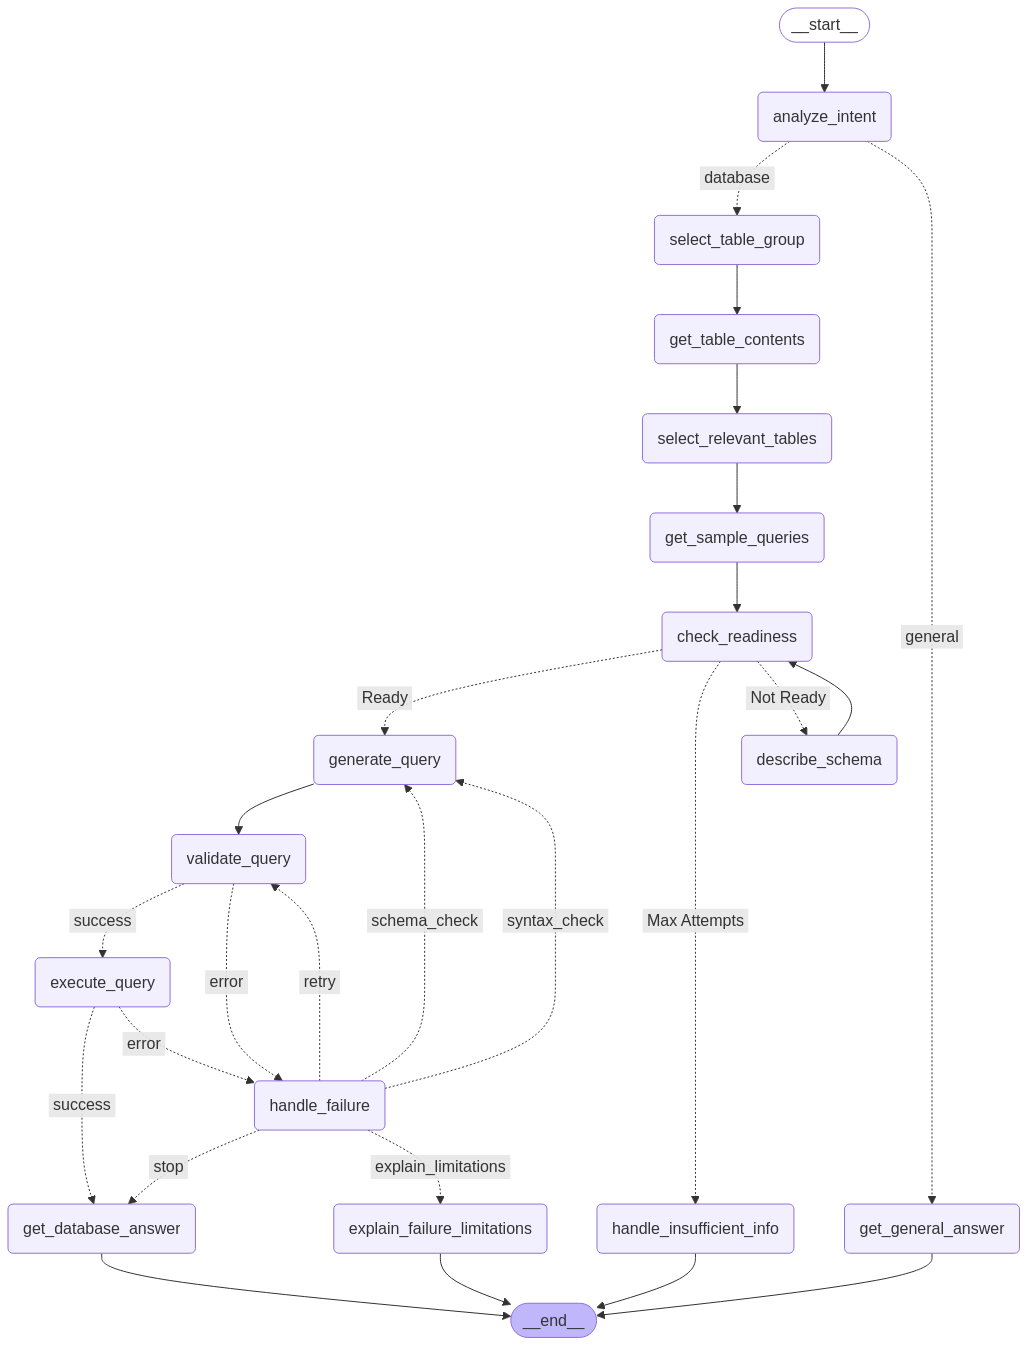

In [136]:
from IPython.display import Image, display

try:
    display(
        Image(app.get_graph(xray=True).draw_mermaid_png())
    )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. 
       # xray=True는 추가적인 세부 정보를 포함합니다.
except Exception as e:
    print(f"그래프 생성 중 오류가 발생했습니다: {str(e)}")
    print(f"오류 유형: {type(e).__name__}")

### LangGraph 워크플로 End-to-End 테스트 

In [113]:
%%time

import pprint
from langgraph.errors import GraphRecursionError
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(
            recursion_limit=100, 
            configurable={"thread_id": "TODO"},
            callbacks=[langfuse_handler]  # 여기에 Langfuse 핸들러 추가}
        )

############
# 음악 관련
############
# inputs = GraphState(question="각 장르별 트랙의 평균 가격과 총 트랙 수를 계산해줘.") # Okay
# inputs = GraphState(question="베토벤이 작곡한 모든 트랙의 이름과 그 트랙이 속한 앨범 제목을 알려줘.") # Okay
# inputs = GraphState(question="평균 트랙 길이가 가장 긴 상위 5명의 아티스트는 누구야?") # Okay
# inputs = GraphState(question="2000년대 이후 발매된 클래식 장르 앨범 중 가장 많은 트랙을 가진 앨범 3개를 찾아줘.") # Okay

############
# 사용자 컨텐츠 관리
############
# inputs = GraphState(question="가장 많은 플레이리스트에 포함된 인기 트랙 5곡은 무엇이야?") # Okay
# inputs = GraphState(question="'Rock'이라는 단어가 포함된 모든 플레이리스트와 각 플레이리스트에 포함된 트랙 수를 보여줘.") # Okay
# inputs = GraphState(question="가장 많은 트랙을 포함하고 있는 상위 10개 플레이리스트는 무엇이야?") # Okay

############
# 비즈니스/판매 관련
############
# inputs = GraphState(question="2022년 매출 상위 10개 국가는?") # Okay
# inputs = GraphState(question="상위 고객 5명의 고객 ID와 총 구매 금액 알려줘") # okay
inputs = GraphState(question="지난 분기에 가장 많은 매출을 올린 5명의 직원과 각 직원이 담당한 고객 수를 보여줘") # Okay
############
# Cross-Domain 관련
############
# inputs = GraphState(question="재즈와 블루스 장르의 트랙만 포함된 플레이리스트를 모두 찾아줘.") # Okay


pp = pprint.PrettyPrinter(width=200, compact=True)

try:
    for output in app.stream(inputs, config=config):
        for key, value in output.items():
            print(f"\n🔹 [NODE] {key}")
            print("=" * 80)
            for k, v in value.items():
                print(f"📌 {k}:")
                pp.pprint(v)
            print("=" * 80)
except GraphRecursionError as e:
    print(f"⚠️ Recursion limit reached: {e}")


🔹 [NODE] analyze_intent
📌 intent:
'database'

🔹 [NODE] select_table_group
📌 selected_group:
'business_sales'
📌 group_tables:
['Customer', 'Employee', 'Invoice', 'InvoiceLine']

🔹 [NODE] get_table_contents
📌 table_contents:
[{'table_name': 'Customer',
  'table_summary': '이 테이블은 고객의 인구통계학적 정보와 연락처 정보를 포함하고 있습니다. 다음과 같은 정보를 담고 있습니다:\n'
                   '\n'
                   '- 고객 ID, 이름, 성, 회사명, 주소, 도시, 주/도, 국가, 우편번호, 전화번호, 팩스번호, 이메일 주소\n'
                   '- 고객을 지원하는 직원 ID\n'
                   '\n'
                   '이 테이블을 활용하면 다음과 같은 분석 및 활용이 가능합니다:\n'
                   '\n'
                   '- 특정 국가 또는 지역 고객 데이터 추출 및 분석 (예: 캐나다, 미국, 브라질 고객 데이터 추출)\n'
                   '- 국가별 고객 분포 및 특성 분석을 통한 맞춤형 마케팅 전략 수립\n'
                   '- 지역별 지원 센터 운영 계획 수립\n'
                   '- 최대 지출 고객 파악을 통한 고객 관계 관리 및 마케팅 전략 수립\n'
                   '- 회사 고객 데이터 추출 및 관리를 통한 비즈니스 관계 유지\n'
                   '- 고객 세그멘테이션 및 타겟팅을 위한 기초 데이터 활용\n'
                   '- 고객 서비스 및 제품 개발을 위한 기초 데이터 